In [57]:
%pip install -qU langchain-groq
%pip install --upgrade --quiet  langchain-community
%pip install langgraph

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached langgraph-0.4.8-py3-none-any.whl.metadata (6.8 kB)
  Using cached langgraph_checkpoint-2.0.26-py3-none-any.whl.metadata (4.6 kB)
  Using cached langgraph_prebuilt-0.2.2-py3-none-any.whl.metadata (4.5 kB)
  Using cached langgraph_sdk-0.1.70-py3-none-any.whl.metadata (1.5 kB)
  Using cached xxhash-3.5.0-cp313-cp313-win_amd64.whl.metadata (13 kB)
  Using cached ormsgpack-1.10.0-cp313-cp313-win_amd64.whl.metadata (44 kB)
Using cached langgraph-0.4.8-py3-none-any.whl (152 kB)
Using cached langgraph_checkpoint-2.0.26-py3-none-any.whl (44 kB)
Using cached ormsgpack-1.10.0-cp313-cp313-win_amd64.whl (121 kB)
Using cached langgraph_prebuilt-0.2.2-py3-none-any.whl (23 kB)
Using cached langgraph_sdk-0.1.70-py3-none-any.whl (49 kB)
Using cached xxhash-3.5.0-cp313-cp313-win_amd64.whl (30 kB)

   ------------- -------------------------- 2/6 [langgraph-sdk]

In [62]:
from langchain_groq import ChatGroq
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.tools import tool
from typing import Annotated, Literal
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
# Load the api key 
import os
from dotenv import load_dotenv
load_dotenv()
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
# print(GROQ_API_KEY)

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


In [4]:
# Create the SQL Connection
import sqlite3
connection = sqlite3.connect("employee.db")
connection

In [5]:
# Create the Tables

table_creation_querys = """
create table if not exists employees(
emp_id integer primary key,
first_name text not null,
last_name text not null,
email text unique not null,
hire_date text not null,
salary real not null
);
"""

table_creation_query2 = """
create table if not exists customers(
customer_id integer primary key autoincrement,
first_name text not null,
last_name text not null,
email text unique not null,
phone text
);
"""

table_creation_query3 = """
create table if not exists orders (
order_id integer primary key autoincrement,
customer_id integer not null,
order_date text not null,
amount real not null,
foreign key (customer_id) references customers (customer_id)
);
"""

In [6]:
cursor = connection.cursor()

In [7]:
cursor.execute(table_creation_querys)
cursor.execute(table_creation_query2)
cursor.execute(table_creation_query3)

In [8]:
insert_query = """
INSERT INTO employees (emp_id, first_name, last_name, email, hire_date, salary)
VALUES (?, ?, ?, ?, ?, ?);
"""

insert_query_customers = """
INSERT INTO customers (customer_id, first_name, last_name, email, phone)
VALUES (?, ?, ?, ?, ?);
"""

insert_query_orders = """
INSERT INTO orders (order_id, customer_id, order_date, amount)
VALUES (?, ?, ?, ?);
"""

In [31]:
# Upload dummy data
employee_data = [
    (1, "Sunny", "Savita", "sunny.sv@abc.com", "2023-06-01", 50000.00),
    (2, "Arhun", "Meheta", "arhun.m@gmail.com", "2022-04-15", 60000.00),
    (3, "Alice", "Johnson", "alice.johnson@jpg.com", "2021-09-30", 55000.00),
    (4, "Bob", "Brown", "bob.brown@uio.com", "2020-01-20", 45000.00),
    ]
customers_data = [
    (1, "John", "Doe", "john.doe@example.com", "1234567890"),
    (2, "Jane", "Smith", "jane.smith@example.com", "9876543210"),
    (3, "Emily", "Davis", "emily.davis@example.com", "4567891230"),
    (4, "Michael", "Brown", "michael.brown@example.com", "7894561230"),
]
orders_data = [
    (1, 1, "2023-12-01", 250.75),
    (2, 2, "2023-11-20", 150.50),
    (3, 3, "2023-11-25", 300.00),
    (4, 4, "2023-12-02", 450.00),
]
connection.commit()

In [32]:
cursor.executemany(insert_query,employee_data)
cursor.executemany(insert_query_customers,customers_data)
cursor.executemany(insert_query_orders,orders_data)
connection.commit()

In [33]:
cursor.execute("select * from employees;")

In [34]:
for row in cursor.fetchall():
    print(row)

(1, 'Sunny', 'Savita', 'sunny.sv@abc.com', '2023-06-01', 50000.0)
(2, 'Arhun', 'Meheta', 'arhun.m@gmail.com', '2022-04-15', 60000.0)
(3, 'Alice', 'Johnson', 'alice.johnson@jpg.com', '2021-09-30', 55000.0)
(4, 'Bob', 'Brown', 'bob.brown@uio.com', '2020-01-20', 45000.0)


In [35]:
cursor.execute("select first_name from employees where salary > 50000.0;")
cursor.fetchall()

[('Arhun',), ('Alice',)]

In [36]:
cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table';")
cursor.fetchall()


[('employees',), ('customers',), ('sqlite_sequence',), ('orders',)]

In [39]:
# Assign LLM model 
llm=ChatGroq(model="llama3-70b-8192",
             temperature = 0.3,
             max_tokens=None,
             timeout=None,
             max_retries=1)


In [40]:
llm.invoke("Do you know what is cricket ?").content

"Cricket is a popular team sport played between two teams, typically consisting of eleven players on each team. It is a bat-and-ball game, where one team takes turns to bat, while the other team fields and bowls.\n\nHere's a brief overview:\n\n**Objective:**\nThe objective of the game is to score runs by hitting the ball with a bat and running between two sets of three stumps (called wickets) while the other team tries to stop them by getting the batsmen out.\n\n**How the game is played:**\n\n1. **Innings:** The game is divided into innings, where one team bats, and the other team fields. Each team gets a chance to bat and bowl.\n2. **Overs:** The game is divided into overs, where a bowler delivers six consecutive balls.\n3. **Batting:** A batsman tries to hit the ball bowled by the opposing team's bowler. They can score runs by running between the wickets or hitting boundaries (four runs) or sixes (six runs).\n4. **Getting out:** A batsman can get out in various ways, such as:\n\t* Bo

In [41]:
# Load the sql database
db = SQLDatabase.from_uri("sqlite:///employee.db")
print("Dialect:", db.dialect)
print("Usable tables:", db.get_usable_table_names())

Dialect: sqlite
Usable tables: ['customers', 'employees', 'orders']


In [42]:
# Access the bd using the Toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
for tool in tools:
    print(tool.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [43]:
list_tables_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)
print(list_tables_tool)
get_schema_tool = next((tool for tool in tools if tool.name == "sql_db_schema"), None)
print(get_schema_tool)

db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001CBB03FBC50>
description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3' db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001CBB03FBC50>


In [44]:
# connection.commit()
print(list_tables_tool.invoke(""))
print(list_tables_tool.invoke("customers"))

customers, employees, orders
customers, employees, orders


In [45]:
print(get_schema_tool.invoke("employees"))


CREATE TABLE employees (
	emp_id INTEGER, 
	first_name TEXT NOT NULL, 
	last_name TEXT NOT NULL, 
	email TEXT NOT NULL, 
	hire_date TEXT NOT NULL, 
	salary REAL NOT NULL, 
	PRIMARY KEY (emp_id), 
	UNIQUE (email)
)

/*
3 rows from employees table:
emp_id	first_name	last_name	email	hire_date	salary
1	Sunny	Savita	sunny.sv@abc.com	2023-06-01	50000.0
2	Arhun	Meheta	arhun.m@gmail.com	2022-04-15	60000.0
3	Alice	Johnson	alice.johnson@jpg.com	2021-09-30	55000.0
*/


In [53]:
# Create the tools  
# @tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and return the result.
    If the query is invalid or returns no result, an error message will be returned.
    In case of an error, the user is advised to rewrite the query and try again.
    """
    result = db.run_no_throw(query)
    print(result)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result
# print(db_query_tool.invoke("SELECT * FROM Employees;"))

In [48]:
# print(db_query_tool.invoke("SELECT * FROM Employees LIMIT 10;"))
db_query_tool("SELECT * FROM employees;")

[(1, 'Sunny', 'Savita', 'sunny.sv@abc.com', '2023-06-01', 50000.0), (2, 'Arhun', 'Meheta', 'arhun.m@gmail.com', '2022-04-15', 60000.0), (3, 'Alice', 'Johnson', 'alice.johnson@jpg.com', '2021-09-30', 55000.0), (4, 'Bob', 'Brown', 'bob.brown@uio.com', '2020-01-20', 45000.0)]


"[(1, 'Sunny', 'Savita', 'sunny.sv@abc.com', '2023-06-01', 50000.0), (2, 'Arhun', 'Meheta', 'arhun.m@gmail.com', '2022-04-15', 60000.0), (3, 'Alice', 'Johnson', 'alice.johnson@jpg.com', '2021-09-30', 55000.0), (4, 'Bob', 'Brown', 'bob.brown@uio.com', '2020-01-20', 45000.0)]"

In [59]:
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")

In [60]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [63]:
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages([("system", query_check_system), ("placeholder", "{messages}")])

query_check = query_check_prompt | llm.bind_tools([db_query_tool])

query_check.invoke({"messages": [("user", "SELECT * FROM Employees LIMIT 5;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_k24r', 'function': {'arguments': '{"query":"SELECT * FROM Employees LIMIT 5;"}', 'name': 'db_query_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 1055, 'total_tokens': 1127, 'completion_time': 0.205714286, 'prompt_time': 0.042304308, 'queue_time': 0.053125963, 'total_time': 0.248018594}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ecd0b210-a7d6-4abd-b281-b56875f70d0f-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Employees LIMIT 5;'}, 'id': 'call_k24r', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1055, 'output_tokens': 72, 'total_tokens': 1127})

In [64]:
# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set.
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database. Do not return any sql query except answer."""


query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system), ("placeholder", "{messages}")])

query_gen = query_gen_prompt | llm.bind_tools([SubmitFinalAnswer])

In [65]:
 def first_tool_call(state:State)->dict[str,list[AIMessage]]:
    return{"messages": [AIMessage(content="",tool_calls=[{"name":"sql_db_list_tables","args":{},"id":"tool_abcd123"}])]}

In [66]:
def handle_tool_error(state:State) -> dict:
    error = state.get("error") 
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
        ToolMessage(content=f"Error: {repr(error)}\n please fix your mistakes.",tool_call_id=tc["id"],)
        for tc in tool_calls
        ]
    }
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")

In [67]:
def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}

In [68]:
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

In [69]:
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

In [71]:
workflow = StateGraph(State)
workflow.add_node("first_tool_call",first_tool_call)
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))
model_get_schema = llm.bind_tools([get_schema_tool])
workflow.add_node("model_get_schema",lambda state: {"messages": [model_get_schema.invoke(state["messages"])],},)
workflow.add_node("query_gen", query_gen_node)
workflow.add_node("correct_query", model_check_query)
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

In [72]:
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges("query_gen",should_continue,)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

In [73]:
app = workflow.compile()

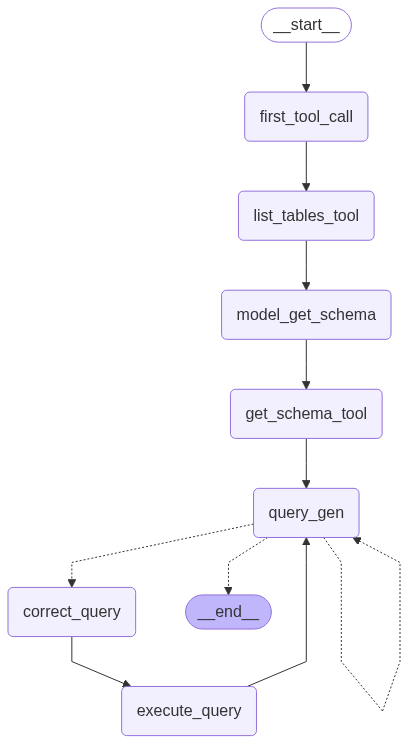

In [74]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [75]:
query={"messages": [("user", "Tell me name of the employee who's salary is more than 30000?")]}
response=app.invoke(query)
response["messages"][-1].tool_calls[0]["args"]["final_answer"]

'Sunny, Arhun, Alice'

In [79]:
query={"messages": [("user", "tell me total numer of order ordered and tell me name as also?")]}
response=app.invoke(query)
response["messages"][-1].tool_calls[0]["args"]["final_answer"]

'The total number of orders is 3. The customers who placed orders are John Doe, Jane Smith, and Emily Davis.'

'There is no Michel in the customers or employees tables.'

In [84]:
query={"messages": [("user", "how many employees are there and tell me the name ??")]}
response=app.invoke(query)
response["messages"][-1].tool_calls[0]["args"]["final_answer"]

'There are 3 employees. Their names are Sunny Savita, Arhun Meheta, Alice Johnson.'